In [1]:
from itertools import product
import random

In [17]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from COVIS_R_based_explicit import RuleBasedSystem;
from COVIS_procedural_system import ProceduralLearningSystem;

(0, 0, 0, 0) A
(0, 0, 0, 1) A
(0, 0, 1, 0) A
(0, 0, 1, 1) A
(0, 1, 0, 0) A
(0, 1, 0, 1) A
(0, 1, 1, 0) A
(0, 1, 1, 1) A
(1, 0, 0, 0) B
(1, 0, 0, 1) B
(1, 0, 1, 0) B
(1, 0, 1, 1) B
(1, 1, 0, 0) B
(1, 1, 0, 1) B
(1, 1, 1, 0) B
(1, 1, 1, 1) B


<Figure size 640x480 with 1 Axes>

prev_pred_r: 0.8044947242686004
prev_obt_r: 1.0

Weights:
 [[0.05118069 0.0034339 ]
 [0.43042598 0.06152841]
 [0.43724212 0.14098178]
 [0.30867831 0.01893777]
 [0.56387621 0.28214553]
 [0.76043977 0.23146078]
 [0.5379834  0.20578221]
 [0.42452901 0.11909295]
 [0.06077839 0.62465763]
 [0.03289635 0.07334002]
 [0.01220776 0.06535737]
 [0.10090571 0.22978666]
 [0.08118332 0.31615947]
 [0.14593896 0.76011765]
 [0.04016405 0.32040102]
 [0.00153512 0.03162756]]


In [29]:
class COVIS(object):
    """
    COVIS has two subsystems: (E)xplicit and (P)rocedural. At each stimulus presentation, COVIS 
    feeds the stimulus to both subsystems and then decides whose prediction to use based on two 
    parameters:
    1. Theta - trust in a given subsystem based on its success history
    2. h - confidence of a given sybsystem in its prediction
    """
    
    def __init__(self, delta_OC, delta_OE, rule_based_params, procedural_params):
        self.delta_OC = delta_OC
        self.delta_OE = delta_OE
        self.rule_based_system = RuleBasedSystem(**rule_based_params)
        self.procedural_system = ProceduralLearningSystem(**procedural_params)
        
        # Initial values for trust (p. 77)
        self.Theta_E = 0.99
        self.Theta_P = 0.01
        
        self.current_prediction_E = None
        self.current_prediction_P = None
        self.current_winner = None
        
    def _feed_stimulus_to_a_system(self, stimulus, system, real_categ):
        """
        Returns (confidence, prediction) of system
        """
        system.process_stimulus(stimulus, real_categ)
        return system.confidence_in_prediction, system.current_prediction
        
    def process_stimulus(self, stimulus, real_categ):
        
        # h_* - absolute value of the normalized discriminant value, not the original value (see p. 76)
        h_E, self.current_prediction_E = self._feed_stimulus_to_a_system(
            stimulus, self.rule_based_system, real_categ)
        h_P, self.current_prediction_P = self._feed_stimulus_to_a_system(
            stimulus, self.procedural_system, real_categ)
        
        # Select whose prediction to use (p. 77)
        if h_E * self.Theta_E > h_P * self.Theta_P:
            self.current_prediction = self.current_prediction_E
            self.predicted_by = self.rule_based_system
        else:
            self.current_prediction = self.current_prediction_P
            self.predicted_by = self.rule_based_system
            
        
        self.process_feedback(real_categ)
        is_correct = self.current_prediction == real_categ
        return is_correct
            
    def process_feedback(self, feedback):
        """
        Updates the trust values
        """
        if self.current_prediction_E == feedback:
            self.Theta_E += self.delta_OC * (1 - self.Theta_E)  # p. 77, Eq. (15)
        else:
            self.Theta_E -= self.delta_OE * self.Theta_E  # p. 77, Eq. (16)
            
        self.Theta_P = 1 - self.Theta_E  # p. 77, paragraph after Eq. (16)        
        
    

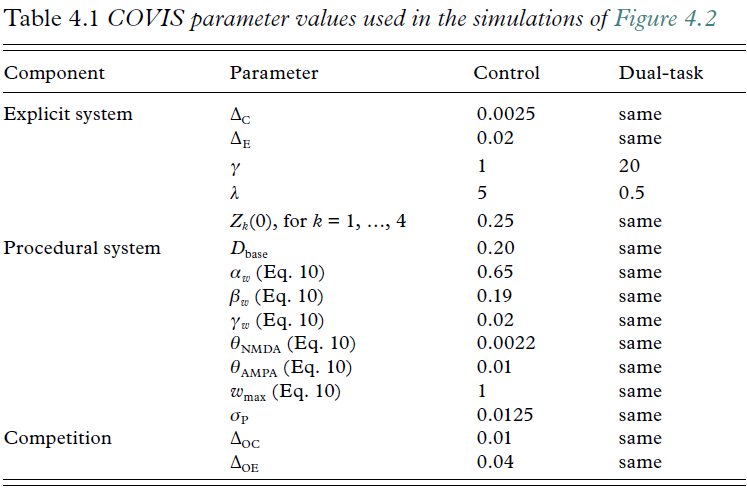

In [31]:
rule_based_params = dict(
    n_dims=4, sigma_e_2=0.0, delta_criterion=0,
    gamma=1.0, lambda_=5.0, 
    delta_C=0.0025, delta_E=0.02, 
)

stimuli = list(product((0, 1), repeat=4))
procedural_params = dict(
    inp_preferred_stimuli=np.array(stimuli), 
    input_scale=0.01,
    categs=("A", "B"), sigma_striatal=0.0125,
    theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
    alpha=0.65, beta=0.19, gamma=0.02,
    w_max=1.0
)

In [36]:
covis = COVIS(
    delta_OC=0.01, 
    delta_OE=0.04,
    rule_based_params=rule_based_params,
    procedural_params=procedural_params
             )

In [37]:
stimuli = list(product((0, 1), repeat=4))
n_stim = len(stimuli)

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

n_blocks = 10
blocks_rb = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(covis.process_stimulus(stimuli[ind], rb_categs[ind]))
    blocks_rb.append(sum(block_hits) / float(n_stim))

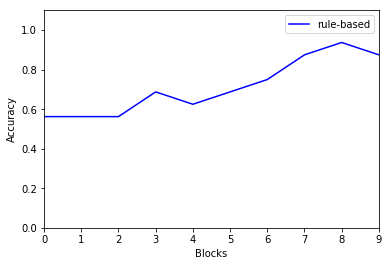

In [38]:
plt.plot(blocks_rb, 'b', label='rule-based')

plt.xlabel('Blocks')
plt.ylabel('Accuracy')

plt.axis([0, n_blocks - 1, 0, 1.1])
plt.legend()

plt.show()